# Tasks - Pose

There are several supported tasks for YOLOv8 (see ultralytics/models/yolo/model.py):
 - detect: detect objects
 - classify: object classification
 - obb: oriented bbox
 - segment: segmentation
 - pose: posture

For YOLOv10, there is only detect for now (see ultralytics/models/yolov10/model.py).
So, in the current notebook we only test the pose task of yolov8.

## Dataset - COCO

An explaination of coco dataset can be found here:
https://machinelearningspace.com/coco-dataset-a-step-by-step-guide-to-loading-and-visualizing/

Person Keypoints has 17 points:

 * 0 nose
 * 1 left_eye
 * 2 right_eye
 * 3 left_ear
 * 4 right_ear
 * 5 left_shoulder
 * 6 right_shoulder
 * 7 left_elbow
 * 8 right_elbow
 * 9 left_wrist
 * 10 right_wrist
 * 11 left_hip
 * 12 right_hip
 * 13 left_knee
 * 14 right_knee
 * 15 left_ankle
 * 16 right_ankle

and their associations are:
 *  0: left_ankle      --> left_knee
 *  1: left_knee       --> left_hip
 *  2: right_ankle     --> right_knee
 *  3: right_knee      --> right_hip
 *  4: left_hip        --> right_hip
 *  5: left_shoulder   --> left_hip
 *  6: right_shoulder  --> right_hip
 *  7: left_shoulder   --> right_shoulder
 *  8: left_shoulder   --> left_elbow
 *  9: right_shoulder  --> right_elbow
 * 10: left_elbow      --> left_wrist
 * 11: right_elbow     --> right_wrist
 * 12: left_eye        --> right_eye
 * 13: nose            --> left_eye
 * 14: nose            --> right_eye
 * 15: left_eye        --> left_ear
 * 16: right_eye       --> right_ear
 * 17: left_ear        --> left_shoulder
 * 18: right_ear       --> right_shoulder


Other datasets may be (only for references):

 * Halpe: https://github.com/Fang-Haoshu/Halpe-FullBody
 * https://mmpose.readthedocs.io/en/latest/dataset_zoo/2d_wholebody_keypoint.html

## Download

In [12]:
%%bash

mkdir data-mscoco
cd data-mscoco

wget -q -nc http://images.cocodataset.org/annotations/annotations_trainval2017.zip
wget -q -nc http://images.cocodataset.org/annotations/image_info_test2017.zip
unzip -q -n ./annotations_trainval2017.zip
unzip -q -n ./image_info_test2017.zip

mkdir images
cd images
wget -q -nc http://images.cocodataset.org/zips/val2017.zip
wget -q -nc http://images.cocodataset.org/zips/train2017.zip
wget -q -nc http://images.cocodataset.org/zips/test2017.zip
unzip -q -n ./val2017.zip
unzip -q -n ./train2017.zip
unzip -q -n ./test2017.zip

## Formatting

The yolo compatible data folder should have the following structure:

      dataset_dir
      |
      --> images
            |
            --> train
            |
            --> val
      --> labels
            |
            --> train
            |
            --> val

In the train and val folder under images are .jpg images and in the train and val folder under labels are .txt files.
The .txt files should correctpond to the .jpg files (have the same name).

And the .txt files contain all object with keypoint information.

For each keypoint object, here is an example:

0 0.468977 0.514602 0.470129 0.714609 0.590982 0.215625 2 0 0 0 0.57971 0.209375 2 0 0 0 0.544283 0.225 2 0 0 0 0.541063 0.301563 2 0 0 0 0.62963 0.3375 2 0 0 0 0.681159 0.298438 2 0.561997 0.498437 2 0.52496 0.498437 1 0.558776 0.675 1 0.446055 0.66875 1 0.504026 0.821875 2 0.301127 0.764062 2

where:
 - the first number (0) is the object label (here 0 is person)
 - the following 4 numbers are the bounding box of the person (0.468977 0.514602 0.470129 0.714609) with the first 2 is the center and last two are the width and height
 - all following numbers represent the keypoints (of shape 3X17). So the first keypoint has coordinates (0.590982 0.215625 2) where the first 2 numbers are the x and y coodinates of the point, and the third number is the visibility (for details, see the section 2. Keypoint Detection in https://cocodataset.org/#format-data).

In [1]:
## create annotations

# code from https://github.com/ryouchinsa/JSON2YOLO
# There is a bug in the code: 
# add 'if 'annotations' in data.keys():' before the line 269
# and we need also the util.py file from https://github.com/ultralytics/JSON2YOLO

# This script will create in the current direction a new folder called 'new_dir'
# and you can changed it to a desired name. In this case, I chnged it to YOLODataset_coco.

# The following infor are displayed in the output:
# kpt_shape: [17, 3]
# flip_idx: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]
# Those are needed in the .yaml file for training.

from json2yolo import convert_coco_json

convert_coco_json("./data-mscoco/annotations", use_segments=False, use_keypoints=True, skip_iscrowd_1=False, rle_to_polygons_holes=False, save_rle_masks=False, cls91to80=False, category_id_starts_from_0=False)

Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/captions_train2017.json: 100%|██████████| 118287/118287 [00:13<00:00, 8901.42it/s]
Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/captions_val2017.json: 100%|██████████| 5000/5000 [00:00<00:00, 9287.30it/s]
Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/image_info_test-dev2017.json: 0it [00:00, ?it/s]
Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/image_info_test2017.json: 0it [00:00, ?it/s]
Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/instances_train2017.json: 100%|██████████| 117266/117266 [00:51<00:00, 2276.59it/s]
Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/instances_val2017.json: 100%|██████████| 4952/4952 [00:02<00:00, 2214.67it/s]


kpt_shape: [17, 3]
flip_idx: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]


Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/person_keypoints_train2017.json: 100%|██████████| 64115/64115 [00:28<00:00, 2238.53it/s]


kpt_shape: [17, 3]
flip_idx: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15]


Annotations /home/niuniu/Documents/DL_pytorch/yolov10/data-mscoco/annotations/person_keypoints_val2017.json: 100%|██████████| 2693/2693 [00:01<00:00, 2308.65it/s]


In [27]:
## copy images

# the above code create only the annotation files
# we need to copy the images by ourself

# After everything setup, rename all folders according to the structure explained above.
# 

import shutil, glob
from pathlib import Path
from tqdm import tqdm

root = './YOLODataset_coco'
keypoint_json = "/labels/person_keypoints"
download_img = "./data-mscoco/images"

for label_dir in glob.glob(root + keypoint_json + "*/"):
    print("copying folder: ", label_dir)
    if "train" in label_dir:
        image_dst = Path(root) / 'images/train'
        image_src= Path(download_img) / 'train2017'
    elif "val" in label_dir:
        image_dst = Path(root) / 'images/val'
        image_src= Path(download_img) / 'val2017'
    elif "test" in label_dir:
        image_dst = Path(root) / 'images/test'
        image_src= Path(download_img) / 'test2017'
    else:
        continue
    
    if not image_dst.exists():
        image_dst.mkdir()

    for file in tqdm(glob.glob(label_dir+"*")):

        file_name = file.split("/")[-1].rstrip("txt")
        image_name = file_name + "jpg"
        shutil.copy(image_src / image_name, image_dst / image_name)




copying folder:  ./YOLODataset_coco/labels/person_keypoints_train2017/


100%|██████████| 64115/64115 [02:10<00:00, 492.18it/s]


copying folder:  ./YOLODataset_coco/labels/person_keypoints_val2017/


100%|██████████| 2693/2693 [00:05<00:00, 453.84it/s]


## Training

My project folder was mounted to the folder "/tmp/yolov10" on the server. So the folder below should be changed if run on other machine.

In [5]:
## setup folder

import sys
sys.path.append("/tmp/yolov10/yolov10")

# set root folder for asset
root = "/tmp/yolov10"

#### Yaml file

For pose task, we need a corresponding yaml file describing the dataset. 
And this file should be passed as training argument.
In this example, we have:

```yaml
path: /tmp/yolov10/YOLODataset_coco # dataset location
train: images/train # relative path for train images
val: images/val # relative path for validation images

# keypoints
kpt_shape: [17, 3] # data shape of the keypoints (eg. 17 keypoints with x, y and v values)
flip_idx: [0, 2, 1, 4, 3, 6, 5, 8, 7, 10, 9, 12, 11, 14, 13, 16, 15] # the index order when flip image horizontally

names:
    0: person # class of the detection
```

In [2]:
## load model

# Here, we use yolov8 model

from ultralytics import YOLO 

model = YOLO("yolov8-pose.yaml")
model.load("./yolov8s-pose.pt")

model

test0:  {'classify': {'model': <class 'ultralytics.nn.tasks.ClassificationModel'>, 'trainer': <class 'ultralytics.models.yolo.classify.train.ClassificationTrainer'>, 'validator': <class 'ultralytics.models.yolo.classify.val.ClassificationValidator'>, 'predictor': <class 'ultralytics.models.yolo.classify.predict.ClassificationPredictor'>}, 'detect': {'model': <class 'ultralytics.nn.tasks.DetectionModel'>, 'trainer': <class 'ultralytics.models.yolo.detect.train.DetectionTrainer'>, 'validator': <class 'ultralytics.models.yolo.detect.val.DetectionValidator'>, 'predictor': <class 'ultralytics.models.yolo.detect.predict.DetectionPredictor'>}, 'segment': {'model': <class 'ultralytics.nn.tasks.SegmentationModel'>, 'trainer': <class 'ultralytics.models.yolo.segment.train.SegmentationTrainer'>, 'validator': <class 'ultralytics.models.yolo.segment.val.SegmentationValidator'>, 'predictor': <class 'ultralytics.models.yolo.segment.predict.SegmentationPredictor'>}, 'pose': {'model': <class 'ultralyti

/tmp/yolov10/yolov10/ultralytics/nn/tasks.py:734: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


YOLO(
  (model): PoseModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(16, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(32, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(48, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(32, eps=0.001, momentum=0.03, affine=True, track_running_stats=

In [3]:
## train

model.train(data=root + "/YOLODataset_coco/dataset.yaml", epochs=100, batch=128, imgsz=640)

New https://pypi.org/project/ultralytics/8.2.92 available 😃 Update with 'pip install -U ultralytics'
test0:  {'classify': {'model': <class 'ultralytics.nn.tasks.ClassificationModel'>, 'trainer': <class 'ultralytics.models.yolo.classify.train.ClassificationTrainer'>, 'validator': <class 'ultralytics.models.yolo.classify.val.ClassificationValidator'>, 'predictor': <class 'ultralytics.models.yolo.classify.predict.ClassificationPredictor'>}, 'detect': {'model': <class 'ultralytics.nn.tasks.DetectionModel'>, 'trainer': <class 'ultralytics.models.yolo.detect.train.DetectionTrainer'>, 'validator': <class 'ultralytics.models.yolo.detect.val.DetectionValidator'>, 'predictor': <class 'ultralytics.models.yolo.detect.predict.DetectionPredictor'>}, 'segment': {'model': <class 'ultralytics.nn.tasks.SegmentationModel'>, 'trainer': <class 'ultralytics.models.yolo.segment.train.SegmentationTrainer'>, 'validator': <class 'ultralytics.models.yolo.segment.val.SegmentationValidator'>, 'predictor': <class '

/tmp/yolov10/yolov10/ultralytics/nn/tasks.py:734: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")
/tmp/yolov10/yolov10/ultralytics/

AMP: checks passed ✅


/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:276: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  self.scaler = torch.cuda.amp.GradScaler(enabled=self.amp)
train: Scanning /tmp/yolov10/YOLODataset_coco/labels/train... 64115 images, 0 backgrounds, 0 corrupt: 100%|██████████| 64115/64115 [03:08<0


train: New cache created: /tmp/yolov10/YOLODataset_coco/labels/train.cache


val: Scanning /tmp/yolov10/YOLODataset_coco/labels/val... 2693 images, 0 backgrounds, 0 corrupt: 100%|██████████| 2693/2693 [00:13<00:00, 1


val: New cache created: /tmp/yolov10/YOLODataset_coco/labels/val.cache
No module named 'seaborn'
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 63 weight(decay=0.0), 73 weight(decay=0.001), 72 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to /tmp/yolov10/yolov10/runs/pose/train4
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      1/100      20.3G      3.038      6.739     0.6412      3.225      2.771        852        640: 100%|██████████| 501/501 [03:52<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.268      0.201      0.148     0.0563     0.0538     0.0276    0.00903    0.00183

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      2/100      20.4G       2.03      5.736     0.4955      2.207      1.855        906        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.474      0.342      0.321      0.143      0.226      0.107     0.0484       0.01

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      3/100      20.5G       1.79      5.034     0.4418       1.83      1.642        939        640: 100%|██████████| 501/501 [03:37<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.577        0.4       0.44      0.225      0.355      0.168      0.122     0.0324

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      4/100      20.1G      1.641      4.522     0.4127        1.6      1.521        697        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.663      0.462      0.531      0.296      0.497      0.244      0.211     0.0684

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      5/100      18.9G      1.547      4.211     0.3917      1.468      1.448        936        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.688      0.498      0.573      0.329      0.528      0.268      0.238     0.0797

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      6/100        19G      1.496      3.993     0.3779      1.394      1.408        956        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.694      0.506      0.586      0.346      0.572      0.286      0.267     0.0979

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      7/100      19.1G       1.46      3.872     0.3691      1.345      1.383       1028        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.693      0.538      0.614       0.37      0.573      0.293      0.272      0.106

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      8/100      19.9G      1.433      3.763     0.3627      1.308       1.36        862        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004       0.72      0.542      0.627      0.379      0.581      0.312      0.288      0.113

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
      9/100      18.3G      1.406      3.691     0.3591      1.274      1.343        767        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.745      0.547      0.637      0.393      0.592      0.327      0.305      0.125

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     10/100      19.1G      1.396      3.613     0.3548      1.255      1.331        869        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.745      0.558      0.654      0.405      0.627      0.329      0.324      0.135

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     11/100      20.4G      1.379       3.58     0.3538      1.236      1.322        767        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.739      0.567      0.658      0.413      0.624       0.34      0.329      0.141

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     12/100      18.8G      1.368      3.513     0.3501      1.218      1.313        915        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.758      0.563      0.661      0.416      0.636       0.34       0.33      0.146

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     13/100        19G      1.359      3.472     0.3468      1.205      1.305        897        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.756      0.571       0.67      0.425      0.641      0.348      0.342      0.155

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     14/100      20.5G      1.348      3.444     0.3462       1.19      1.297        936        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.744      0.588      0.677      0.431      0.673      0.348       0.35      0.161

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     15/100        19G      1.343      3.388     0.3438      1.183      1.292        925        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.766      0.583      0.681      0.437      0.652      0.357      0.356      0.168

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     16/100      20.5G      1.329      3.372     0.3417      1.169      1.286        751        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.759       0.59      0.684       0.44      0.665      0.357      0.356       0.17

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     17/100      19.9G      1.325      3.333     0.3397       1.16      1.281        994        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.764      0.593       0.69      0.445      0.647      0.365      0.362      0.174

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     18/100      19.6G      1.321      3.324     0.3398      1.158      1.279        854        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.772      0.595      0.693       0.45       0.66      0.367      0.368      0.179

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     19/100      18.9G      1.316      3.291      0.338      1.146      1.273        834        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.766      0.602      0.699      0.454      0.663      0.367      0.368      0.181

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     20/100      19.1G      1.309      3.272     0.3365      1.142      1.271        832        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.764      0.605      0.699      0.457      0.662       0.37       0.37      0.183

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     21/100      19.7G      1.307      3.259     0.3366      1.138       1.27        889        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004       0.77      0.609      0.702      0.459      0.648      0.376      0.375      0.187

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     22/100      20.4G      1.301      3.224      0.334      1.129      1.263        889        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.778      0.606      0.705      0.462      0.665      0.374      0.377       0.19

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     23/100      18.8G      1.296      3.212     0.3336      1.123      1.262        879        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004       0.78      0.606      0.707      0.464      0.669      0.374      0.376      0.191

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     24/100      19.1G      1.293      3.189     0.3323      1.119      1.258        897        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.772      0.611      0.708      0.465      0.676      0.374      0.379      0.194

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     25/100        19G      1.292      3.185     0.3322      1.115      1.257        852        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.769      0.617       0.71      0.468      0.678       0.38      0.382      0.196

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     26/100      19.1G      1.289      3.157     0.3307      1.111      1.256        846        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.779      0.618      0.712       0.47      0.678      0.377      0.381      0.197

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     27/100      19.8G      1.277      3.147     0.3296        1.1      1.249        899        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.783      0.616      0.713       0.47      0.682      0.378      0.383      0.198

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     28/100      19.1G      1.278      3.135     0.3292        1.1      1.249        871        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.781      0.617      0.714      0.471      0.675      0.381      0.384      0.199

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     29/100      19.3G      1.279       3.12     0.3289      1.099      1.248        802        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.773      0.623      0.715      0.473      0.689      0.376      0.384        0.2

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     30/100      19.5G      1.274      3.113     0.3282      1.094      1.247        789        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.773      0.622      0.717      0.474      0.681      0.381      0.386      0.201

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     31/100      20.5G      1.274      3.106     0.3276      1.089      1.246        858        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.786      0.617      0.717      0.475      0.688       0.38      0.387      0.202

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     32/100        18G      1.269      3.091     0.3263      1.086      1.243        880        640: 100%|██████████| 501/501 [03:39<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.791      0.615      0.718      0.475      0.685      0.382      0.389      0.205

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     33/100        20G      1.267      3.065     0.3257      1.082       1.24        947        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.783      0.621      0.719      0.476      0.686      0.383      0.389      0.205

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     34/100      19.5G      1.268      3.057     0.3261      1.082      1.241        977        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.785       0.62       0.72      0.476      0.683      0.384      0.389      0.206

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     35/100      20.4G      1.262      3.052     0.3243      1.079      1.238        799        640: 100%|██████████| 501/501 [03:38<00:00,
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95)     Pose(P          R      mAP50  mAP50-95): 100%|


                   all       2693      11004      0.785      0.621       0.72      0.477      0.678      0.386       0.39      0.207

      Epoch    GPU_mem   box_loss  pose_loss  kobj_loss   cls_loss   dfl_loss  Instances       Size


  0%|          | 0/501 [00:00<?, ?it/s]/tmp/yolov10/yolov10/ultralytics/engine/trainer.py:379: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(self.amp):
     36/100        18G      1.267      3.042     0.3257      1.082      1.237       1002        640:  21%|██        | 104/501 [00:45<02:54,


KeyboardInterrupt: 

## Inference

/home/niuniu/Documents/DL_pytorch/yolov10/yolov10/ultralytics/nn/tasks.py:734: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(file, map_location="cpu")


test0:  {'classify': {'model': <class 'ultralytics.nn.tasks.ClassificationModel'>, 'trainer': <class 'ultralytics.models.yolo.classify.train.ClassificationTrainer'>, 'validator': <class 'ultralytics.models.yolo.classify.val.ClassificationValidator'>, 'predictor': <class 'ultralytics.models.yolo.classify.predict.ClassificationPredictor'>}, 'detect': {'model': <class 'ultralytics.nn.tasks.DetectionModel'>, 'trainer': <class 'ultralytics.models.yolo.detect.train.DetectionTrainer'>, 'validator': <class 'ultralytics.models.yolo.detect.val.DetectionValidator'>, 'predictor': <class 'ultralytics.models.yolo.detect.predict.DetectionPredictor'>}, 'segment': {'model': <class 'ultralytics.nn.tasks.SegmentationModel'>, 'trainer': <class 'ultralytics.models.yolo.segment.train.SegmentationTrainer'>, 'validator': <class 'ultralytics.models.yolo.segment.val.SegmentationValidator'>, 'predictor': <class 'ultralytics.models.yolo.segment.predict.SegmentationPredictor'>}, 'pose': {'model': <class 'ultralyti

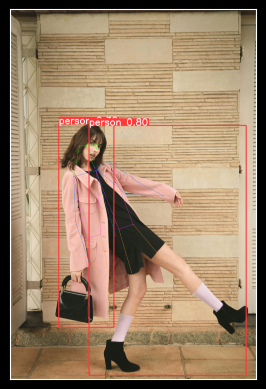

In [13]:
# To get better result, we need to train more (my train stopped at 36 epoch).

import cv2
from ultralytics import YOLO 
import matplotlib.pyplot as plt

%matplotlib inline

model = YOLO("./yolov10/runs/pose/train4/weights/best.pt")
# model = YOLO("./yolov8s-pose.pt")

img_path = "./posture0.jpg"
img = cv2.imread(img_path)

result = model(source=img_path, imgsz=640)[0].plot()[:, :, ::-1]
result

plt.imshow(result)
plt.xticks([])
plt.yticks([])
plt.show()